# Stationrank

In [1]:
import os
import time
import json
#import pygraphviz

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import networkx as nx
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
from networkx.drawing.nx_agraph import write_dot
from networkx.readwrite import json_graph
#from shapely.geometry import Point, LineString
#from shapely_geojson import dump, dumps, Feature, FeatureCollection
from tqdm.notebook import trange, tqdm
from scipy.linalg import norm
from scipy.linalg import eig
from matplotlib import cm
from ipywidgets import interact, interact_manual
from itertools import compress
from datetime import datetime, timedelta
from sklearn import preprocessing
from numpy import linalg as LA
from numpy import nan

## Loading the dataset

In [4]:
# Set month
month = 'Oktober'

# Set index
imonth = '10'

In [5]:
# Clean data contains every "stop" for a month for all swiss railways
data = pd.read_pickle('data/istdaten/{}/data_clean_2019{}.pkl'.format(month, imonth))

In [ ]:
# Check if all days are in
print(data.BETRIEBSTAG.unique())

In [ ]:
data.head()

## Load stations dataset (didok)

In [6]:
# Full didok data
didok = pd.read_csv('data/istdaten/{}/dienststellenfull.csv'.format(month), header=6, sep=";")

In [7]:
# Coordinates
didok = didok[['BPUIC', 'BEZEICHNUNG_OFFIZIELL', 'E_WGS84', 'N_WGS84']].drop_duplicates()
didok = didok[np.isfinite(didok['E_WGS84'])]
didok = didok.reset_index()
didok = didok.drop(columns=['index'])
didok.head(5)

,BPUIC,BEZEICHNUNG_OFFIZIELL,E_WGS84,N_WGS84
0,8504048,"Villariaz, Moulin Rouge",-14.801849,35.100356
1,8504049,"Villarepos, F. de Plan",-14.764508,35.330601
2,8519024,Basel SBB RB West,-8.092301,55.603118
3,8519025,Basel SBB RB Ost,-8.073794,55.600495
4,8557043,"Ennetbaden, Rütenen-Felmen",0.379039,47.265918


### Locations in project as BPUIC

In [8]:
# These are the specific stations of the project
locations = data.copy(deep=True)
locations = locations[['HALTESTELLEN_NAME', 'BPUIC']].drop_duplicates()
locations.BPUIC = locations.BPUIC.astype(int)
locations = locations.reset_index()
locations = locations.drop(columns=['index'])
locations

,HALTESTELLEN_NAME,BPUIC
0,Basel Bad Bf,8500090
1,Basel SBB,8500010
2,Schaffhausen,8503424
3,Zürich HB,8503000
4,Bern,8507000
...,...,...
1240,Genève-Champel,8516272
1241,Lancy-Bachet,8517142
1242,Genève Voie-Creuse,8519692
1243,Niederbottigen BN,8504492


### Georeferenced locations by BPUIC

In [9]:
geopos = []
abbreviation = []
for i, location in enumerate(locations.values):
    lon = didok.loc[didok['BPUIC']==location[1]].values[0][2]
    lat = didok.loc[didok['BPUIC']==location[1]].values[0][3]
    loc = [lon, lat]
    geopos.append(loc)

In [10]:
locations['geopos'] = geopos
locations.head(5)

,HALTESTELLEN_NAME,BPUIC,geopos
0,Basel Bad Bf,8500090,"[7.60728379, 47.56814685]"
1,Basel SBB,8500010,"[7.58955093, 47.54740464]"
2,Schaffhausen,8503424,"[8.632719999999999, 47.69827999]"
3,Zürich HB,8503000,"[8.540189999999999, 47.378170000000004]"
4,Bern,8507000,"[7.43911848, 46.94882499]"


## Preprocessing (please use precomputed results)

In [ ]:
def discretize(x):
    if pd.isna(x):
        return None
    else:
        x = pd.to_datetime(x)
        return int((x.hour) * 60 + x.minute)

In [ ]:
def span(x):
    if pd.isna(x['arrival']) ^ pd.isna(x['departure']):
        return 1
    elif pd.isna(x['arrival']) and pd.isna(x['departure']):
        return None
    else:
        diff = x['departure'] - x['arrival']
        if diff >= 0:
            return diff + 1
        else:
            return None

In [ ]:
def timeline(lst, df):
    if pd.isna(df.loc[df.index[0]].arrival):
        start = int(df.loc[df.index[0]].departure)
    else:
        start = int(df.loc[df.index[0]].arrival)
    primer = {int(i): None for i in range(0, start)}
    main = {int(j + start): [lst[j]] for j in range(0, len(lst))}
    sequel = {int(k): None for k in range(start + len(lst), 60 * 24)}
    main.update(sequel)
    primer.update(main)
    return primer

In [ ]:
# Collect features
features = []
# One feature per day
for day in data['BETRIEBSTAG'].unique():
    feature = data[data['BETRIEBSTAG'] == day]
    # Reset index
    feature = feature.reset_index()
    feature = feature.drop(columns=['index'])
    features.append(feature)

In [ ]:
# Collect diaries
diaries = []

for feature in tqdm(features):

    # Diary of routes
    diary = []
    for route in tqdm(
            feature.FAHRT_BEZEICHNER.unique(),
            desc=feature['BETRIEBSTAG'].unique()[0]):

        df = feature.loc[(feature.FAHRT_BEZEICHNER == route)]

        if len(df['HALTESTELLEN_NAME']) > 1:

            df['arrival'] = df['ANKUNFTSZEIT'].apply(discretize)
            df['departure'] = df['ABFAHRTSZEIT'].apply(discretize)

            # Sort routes by scheduled departure
            df = df.sort_values(
                by='ABFAHRTSZEIT', ascending=True, na_position='last')

            df['dwell'] = df[['arrival', 'departure']].apply(span, axis=1)
            df['running'] = df['arrival'].shift(-1) - df['departure'] - 1

            # Check for timetable errors
            if any(df['running'].values.ravel() < 0):
                continue
            if any(df['dwell'].values.ravel() < 0):
                continue

            df['next'] = df['HALTESTELLEN_NAME'].shift(-1)

            sentence = []
            for i, j, k, l in df[[
                    'HALTESTELLEN_NAME', 'next', 'dwell', 'running'
            ]].values:
                if pd.isna(j) or pd.isna(l):
                    sentence.append([i])
                    
                elif pd.isna(k):
                    sentence.append([i])
                    break
                else:
                    sentence.append([i] * int(k))
                    sentence.append([i + '=>' + j] * int(l))

            flattened = [item for sublist in sentence for item in sublist]
            dic = timeline(flattened, df)
            if len(dic) != 1440:
                print(len(dic))
                break
            diary.append(dic)

    # Fill in the diaries
    diaries.append(pd.DataFrame(diary))

## Save the diaries for later use

In [ ]:
# Export all diaries
for i, diary in enumerate(diaries):
    path = 'data/istdaten/{}/diaries/diary_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    diary.to_pickle(path)

## Load preprocessed data

In [ ]:
Diaries = []
directory = 'data/istdaten/{}/diaries/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    d = pd.read_pickle(path)
    Diaries.append(d)

## Model construction

In [ ]:
# Collect starting vectors
vectors = []
# Collect transition matrices
matrices = []
# Collect states
states = []

In [ ]:
for diary in tqdm(Diaries):

    # Dictionary of stations
    dic = {'station': np.unique([x for x in diary.values.ravel() if x != None])}
    stations = pd.DataFrame(dic)
    states.append(stations)

    # Size of the matrix
    n = stations.shape[0]
    
    # Initialize a n*1 initial start vector
    t = (n)
    Vector = pd.DataFrame(np.zeros(t))
    origin = pd.DataFrame(np.zeros(t))
    
    # Initialize a n*n transition matrix
    s = (n, n)
    matrix = pd.DataFrame(np.zeros(s))

    for row in tqdm(diary.values):
        route = [x for x in row if x != None]
        stops = [item for sublist in route for item in sublist]
          
        # Initial vector
        pos_i = stations.loc[stations['station'] == stops[0]].index[0]
        origin.iloc[pos_i] += 1

        # Transition matrix
        for i in range(len(stops) - 1):
            pos1 = stations.loc[stations['station'] == stops[i]].index[0]
            pos2 = stations.loc[stations['station'] == stops[i + 1]].index[0]  
            matrix.iloc[pos1, pos2] += 1
            
    # Fill in the vectors
    inflow = matrix.sum(axis=0)
    outflow = matrix.sum(axis=1)
    
    Vector['station'] = dic['station']
    Vector['origin'] = origin/origin.sum()
    Vector['inflow'] = inflow/inflow.sum()
    Vector['outflow'] = outflow/outflow.sum()
    Vector = Vector.drop(columns=[0])
    vectors.append(Vector)

    # Fill in the matrices
    matrix.columns = dic['station']
    matrix = matrix.set_index(dic['station'])
    matrices.append(matrix)

### Save the model for later use

In [ ]:
# Export all vectors
for i, vector in enumerate(vectors):
    path = 'data/istdaten/{}/vectors/vector_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    vector.to_pickle(path)

In [ ]:
# Export all matrices
for i, matrix in enumerate(matrices):
    path = 'data/istdaten/{}/matrices/matrix_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    matrix.to_pickle(path)

### Loading the model

In [11]:
# Load starting vectors
Vs = []
directory = 'data/istdaten/{}/vectors/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    V = pd.read_pickle(path)
    Vs.append(V)

In [12]:
# Load original transition matrices
OTMs = []
directory = 'data/istdaten/{}/matrices/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory,file)
    OTM = pd.read_pickle(path)
    OTMs.append(OTM)

In [13]:
strings = []
for i in range(1, len(Vs)+1):
    string = '{:>02}.{}'.format(i, imonth)
    strings.append(string)

## Calculate Probabilities

In [125]:
TMs = []
row_singularities = []
column_singularities = []

for i, OTM in tqdm(enumerate(OTMs)):
    TM = OTM.copy(deep=True)
    eps = 0.001
    
    count = 0
    
    for column in TM.values.T:
        column_singularities.append([])
        
        selfloop = TM.values[count][count]
        
        if (sum(column) - selfloop == 0):
            singularity = Vs[i].iloc[count][0]
            column_singularities[i].append(singularity)
            print('Singular Origin at', singularity)
            column[:] = eps
            column[count] = selfloop        
        TM.values.T[count]=column
        count+=1    
    
    count = 0
        
    for row in TM.values:
        row_singularities.append([])
        
        selfloop = TM.values[count][count]
        
        total = sum(row)
        
        if (sum(row) - selfloop == 0):
            singularity = Vs[i].iloc[count][0]
            row_singularities[i].append(singularity)
            print('Singular Terminal at', singularity)
            row[:] = eps
            row[count] = 1.0
            row[:] = [r / sum(row) for r in row]
        elif (sum(row) - selfloop == eps):
            singularity = Vs[i].iloc[count][0]
            row_singularities[i].append(singularity)
            print('Singular Terminal at', singularity)
            row[:] = eps
            row[count] = 1.0
            row[:] = [r / sum(row) for r in row]        
        else:
            row[:] = [r / total for r in row]
        TM.values[count]=row
        count+=1
        
    TMs.append(TM)

Singular Terminal at Chiasso Olimpino I
Singular Origin at Landesgrenze CH-Liechtenstein
Singular Origin at Schaffhausen Nord
Singular Terminal at Sagliains Abzw Sasslatschtunne
Singular Origin at Schaffhausen Nord
Singular Terminal at Gaggiolo Confine
Singular Terminal at La Plaine-Frontière
Singular Origin at Gaggiolo Confine
Singular Origin at La Plaine-Frontière
Singular Origin at Landesgrenze CH-Liechtenstein
Singular Terminal at Le Locle-Frontière
Singular Origin at Chêne-Bourg
Singular Terminal at Genève Voie-Creuse



In [73]:
# Overview of singularities in the system by day of occurance
singular_rows = pd.DataFrame(row_singularities).dropna(how ='all')
singular_rows

,0
2,Chiasso Olimpino I
7,Sagliains Abzw Sasslatschtunne
16,Gaggiolo Confine
19,La Plaine-Frontière
22,Le Locle-Frontière
28,Genève Voie-Creuse


In [74]:
# Overview of singularities in the system by day of occurance
singular_columns = pd.DataFrame(column_singularities).dropna(how ='all')
singular_columns

,0,1,2
3,Landesgrenze CH-Liechtenstein,None,None
6,Schaffhausen Nord,None,None
10,Schaffhausen Nord,None,None
20,Gaggiolo Confine,La Plaine-Frontière,Landesgrenze CH-Liechtenstein
28,Chêne-Bourg,None,None


In [285]:
# Export all probabilities
for i, probability in enumerate(TMs):
    path = 'data/istdaten/{}/probability/probability_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    probability.to_pickle(path)

In [14]:
# Load probabilities
TMs = []
directory = 'data/istdaten/{}/probability/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory,file)
    TM = pd.read_pickle(path)
    TMs.append(TM)

In [15]:
# Matrix size
sizes = []
for TM in TMs:
    size = TM.shape[0]
    sizes.append(size)

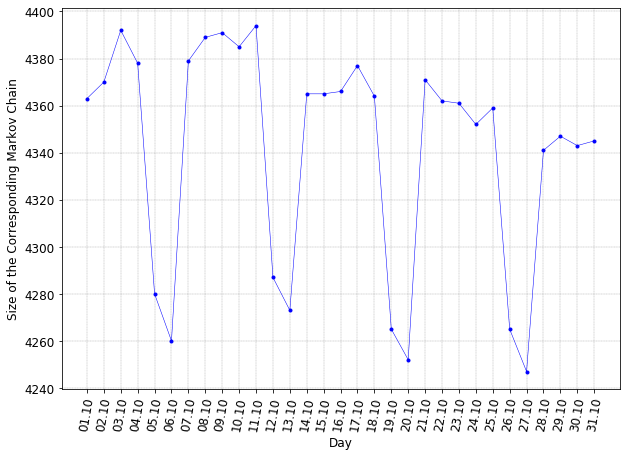

In [17]:
# Plot size
fig = plt.figure(figsize=(10, 7));
plt.plot(sizes, '.-b', linewidth=.51)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Size of the Corresponding Markov Chain')
plt.xlabel('Day')
xticks=[s for s in strings]
plt.xticks(range(len(sizes)), xticks, rotation=80, horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

#path = 'C:/Users/GAO/Desktop/ML/ETH/Paper/size.jpg'
#fig.savefig(path, dpi=300)

plt.show()
plt.close()

### Common indices

In [240]:
initial_states = []
for i, vector in enumerate(Vs):
    _vector = vector.copy(deep=True)    
    _vector['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    _vector['Flag'] = ~_vector['station'].str.contains('=>')
    _vector = _vector[_vector['Flag']]
    initial_states.append(_vector)

In [241]:
selected_states = []
for state in initial_states:
    state = state[state['Flag']]
    state.set_index('station', inplace=True)
    selected_states.append(state)

In [242]:
# Merge stations over whole month
merge = pd.concat(selected_states, axis=1, join='inner')

In [243]:
# Get common indices
indices = merge.index.values

In [244]:
len(indices)

1194

In [245]:
commonloc = locations.copy(deep=True)
commonloc = commonloc[commonloc['HALTESTELLEN_NAME'].isin(indices)]
commonloc.sort_values('HALTESTELLEN_NAME', inplace=True)
commonloc.set_index('HALTESTELLEN_NAME', inplace=True)

## Analysis

In [25]:
def Analyze(MC, verbose='on'):
    e1 = time.time()    
    w, vl, vr = eig(MC, left=True)
    
    w = np.real(w)
    vl = np.real(vl)
    
    idx = np.argsort(w)
    w = w[idx]
    vl = vl[:,idx]
    
    eigvec_1 = (vl[:,-1])/(vl[:,-1]).sum()
    eigvec_2 = (vl[:,-2])
    
    ind = np.around(w,decimals=8)!=1
    K = np.divide(1,(1-w[ind])).sum()
    if verbose == 'on':
        print('Analysis in {}'.format(time.time() - e1))

    return eigvec_1, eigvec_2, K

### Calibration on Toy Matrix

In [23]:
#Example from Kirkland
P = np.array([[0, 0, 0.1, 0.9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.1, 0.8, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0.1, 0.9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.8, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0.9, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0.9, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.9, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.9],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.8, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9, 0.1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.8, 0.1, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9, 0.1, 0, 0]])

In [24]:
print(P)

[[0.  0.  0.1 0.9 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.9 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.8 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.9 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.9 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.9 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.9]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.8 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 0.1]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  

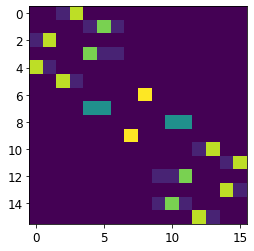

In [25]:
plt.imshow(P);

In [26]:
AP = Analyze(P)

Analysis in 0.0009999275207519531


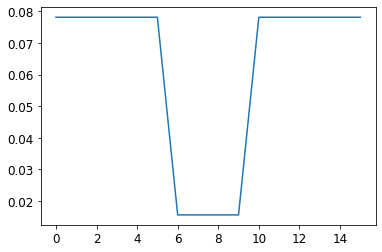

In [27]:
# First Eigenvector of P
plt.plot(AP[0]);

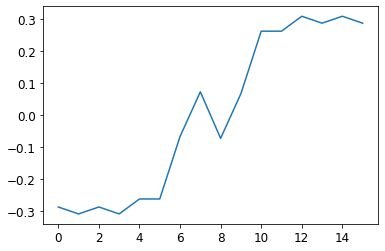

In [28]:
# Second Eigenvector of P
plt.plot(AP[1]);

### Compute Eigenvectors

In [135]:
ATMs = []
sign = []

for TM in TMs:
    ATM = Analyze(TM.values, verbose='on')
    ATMs.append(ATM)    
    sign.append(ATM[0].min()>0)

Analysis in 66.5708076953888
Analysis in 67.74287462234497
Analysis in 66.62281036376953
Analysis in 67.40785551071167
Analysis in 65.38273978233337
Analysis in 62.01754689216614
Analysis in 66.85482406616211
Analysis in 67.88588285446167
Analysis in 67.23784589767456
Analysis in 67.73787426948547
Analysis in 67.91788458824158
Analysis in 64.93071389198303
Analysis in 63.6806423664093
Analysis in 67.31485033035278
Analysis in 67.99388909339905
Analysis in 69.32396507263184
Analysis in 70.14201188087463
Analysis in 70.04400634765625
Analysis in 66.17578530311584
Analysis in 63.72164440155029
Analysis in 70.93805742263794
Analysis in 70.28101992607117
Analysis in 70.77604818344116
Analysis in 68.48391699790955
Analysis in 70.21301603317261
Analysis in 64.82970809936523
Analysis in 64.56669282913208
Analysis in 68.00488996505737
Analysis in 67.67387104034424
Analysis in 66.78081965446472
Analysis in 67.29684925079346


In [136]:
print(sign)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


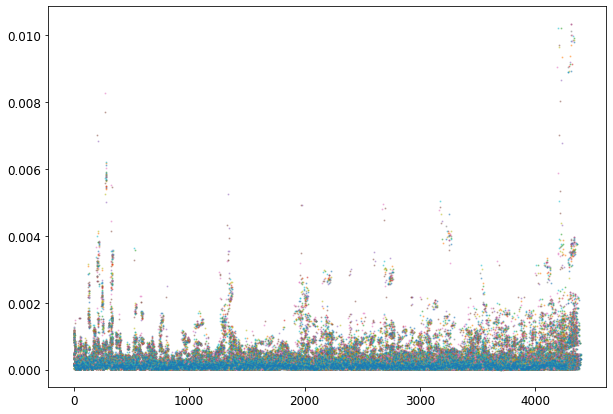

In [207]:
fig = plt.figure(figsize=(10, 7));
font = {'size': 12}
plt.rc('font', **font)
for i in range(len(ATMs)):
    plt.plot((ATMs[i][0]), '.', alpha=.4, markersize=2.0);

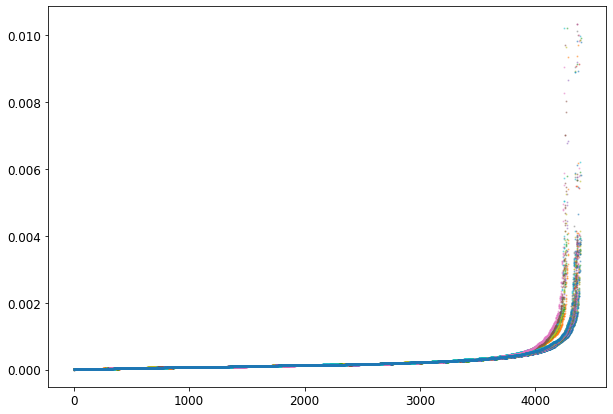

In [209]:
fig = plt.figure(figsize=(10, 7));
font = {'size': 12}
plt.rc('font', **font)
for i in range(len(ATMs)):
    plt.plot(np.sort(ATMs[i][0]), '.', alpha=.4, markersize=2.0);

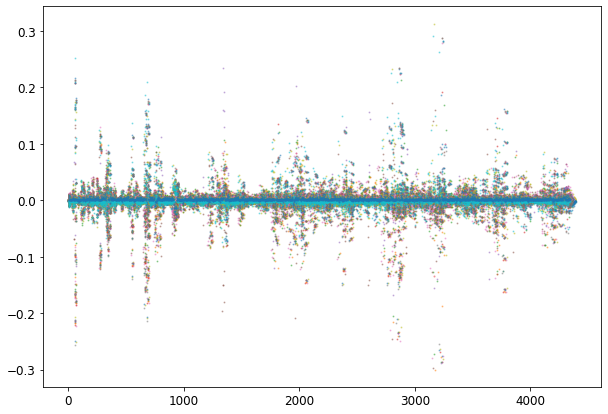

In [212]:
fig = plt.figure(figsize=(10, 7));
font = {'size': 12}
plt.rc('font', **font)
for i in range(len(ATMs)):
    plt.plot((ATMs[i][1]), '.', alpha=.4, markersize=2.0);

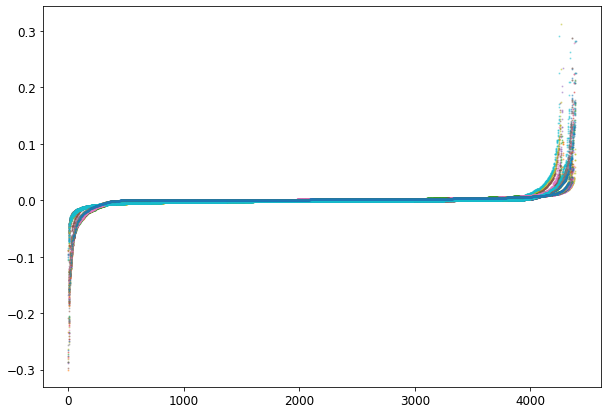

In [213]:
fig = plt.figure(figsize=(10, 7));
font = {'size': 12}
plt.rc('font', **font)
for i in range(len(ATMs)):
    plt.plot(np.sort(ATMs[i][1]), '.', alpha=.4, markersize=2.0);

In [176]:
Kemenys = []
for i in range(len(ATMs)):
    Kemenys.append(ATMs[i][2])

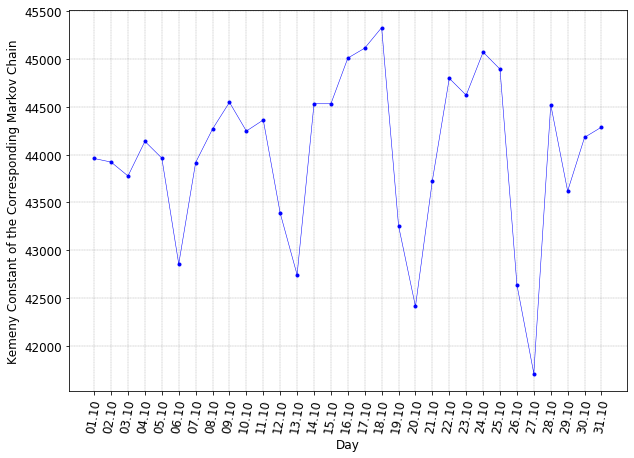

In [178]:
# Plot size
fig = plt.figure(figsize=(10, 7));
plt.plot(Kemenys, '.-b', linewidth=.51)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Kemeny Constant of the Corresponding Markov Chain')
plt.xlabel('Day')
xticks=[s for s in strings]
plt.xticks(range(len(sizes)), xticks, rotation=80, horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

#path = 'C:/Users/GAO/Desktop/ML/ETH/Paper/size.jpg'
#fig.savefig(path, dpi=300)

plt.show()
plt.close()

## Sensitivity analysis of Markov chains

In [44]:
# Simultaneous Perturbation on incoming edges
def perturb(M, i, p):

    MC = M.copy()
    n = MC.shape[0]
    
    ei = np.zeros(shape=[n, 1])
    ei[i][0] = 1

    ep = np.zeros(shape=[n, 1])
    subtotal = 0
    for r in p:
        subtotal += MC[i][r]
    for r in p:
        ep[r][0] = MC[i][r] / subtotal
        
    fraction = subtotal / (1 - subtotal)

    if subtotal < 1:
        P = fraction * np.dot(ei, (np.dot(ei.T, MC) - ep.T))
    elif len(p)==1 and subtotal == 1:
        MC[i][p[0]] = -1
        MC[i][i] = 1
        P = MC
    return P

### Validation on Toy Matrix

In [214]:
# Modified Example from Kirkland
E = np.array([[0, 0, 0.1, 0.9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.1, 0.5, 0.1, 0.3, 0, 0, 0, 0, 0, 0, 0, 0],
               [0.1, 0.9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.8, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0.9, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0.9, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.9, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.9],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.8, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9, 0.1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.8, 0.1, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9, 0.1, 0, 0]])

In [216]:
print(E)

[[0.  0.  0.1 0.9 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.5 0.1 0.3 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.9 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.8 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.9 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.9 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.9 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.9]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.8 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 0.1]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  

In [215]:
print(perturb(E, 1, [5,6])[1])

[ 0.    0.    0.    0.    0.15 -0.5  -0.1   0.45  0.    0.    0.    0.
  0.    0.    0.    0.  ]


### Compute Perturbation on the Data

In [286]:
d = 0

In [259]:
TM = TMs[d].copy(deep=True)
TM.head()

,Aadorf,Aadorf=>Elgg,Aadorf=>Guntershausen,Aarau,Aarau=>Brugg AG,Aarau=>Lenzburg,Aarau=>Olten,Aarau=>Rupperswil,Aarau=>Schönenwerd SO,Aarau=>Sissach,...,Zürich Tiefenbrunnen=>Zürich Stadelhofen,Zürich Wiedikon,Zürich Wiedikon=>Zürich Enge,Zürich Wiedikon=>Zürich HB,Zürich Wipkingen,Zürich Wipkingen=>Zürich HB,Zürich Wipkingen=>Zürich Oerlikon,Zürich Wollishofen,Zürich Wollishofen=>Kilchberg,Zürich Wollishofen=>Zürich Enge
Aadorf,0.0,0.452381,0.547619,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aadorf=>Elgg,0.0,0.500000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aadorf=>Guntershausen,0.0,0.000000,0.500000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aarau,0.0,0.000000,0.000000,0.476522,0.033043,0.14087,0.093913,0.106087,0.066087,0.029565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aarau=>Brugg AG,0.0,0.000000,0.000000,0.000000,0.915556,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [260]:
TM = TM.values.copy()

In [261]:
target = 'Winterthur'

In [262]:
p = np.where(TMs[d].index == target)[0][0]
p

4096

In [263]:
inbound = list(np.asarray(np.where(TM[:,p] > 0))[0])
if p in inbound:
    inbound.remove(p)

incoming = []
for n, i in enumerate(inbound):
    a = list(np.asarray(np.where(TM[:,i] > 0))[0])
    if i in a:
        a.remove(i)
    if len(a)>1:
        inbound[n] = p
        a = [i]
    incoming.append(a[0])

In [264]:
incoming

[100, 1071, 1281, 1590, 1766, 2722, 3543, 3650, 4066, 4097, 4107, 4299, 4343]

In [265]:
inbound

[104, 1076, 1285, 1592, 1768, 2724, 3568, 3653, 4071, 4098, 4108, 4301, 4348]

In [266]:
dictionary = dict(zip(inbound, incoming))

In [267]:
from operator import itemgetter
from itertools import groupby

snd = itemgetter(1)

def sort_and_group(itr, f):
    return groupby(sorted(itr, key=f), f)

mydict = dictionary
reversed_dict = {number: [char for char,_ in v] 
                 for number, v in sort_and_group(mydict.items(), snd)}

In [268]:
reversed_dict

{100: [104],
 1071: [1076],
 1281: [1285],
 1590: [1592],
 1766: [1768],
 2722: [2724],
 3543: [3568],
 3650: [3653],
 4066: [4071],
 4097: [4098],
 4107: [4108],
 4299: [4301],
 4343: [4348]}

In [269]:
for k, v in reversed_dict.items():
    print(TMs[d].iloc[k].name, TMs[d].iloc[v].index.values)

Andelfingen ['Andelfingen=>Winterthur']
Effretikon ['Effretikon=>Winterthur']
Frauenfeld ['Frauenfeld=>Winterthur']
Hettlingen ['Hettlingen=>Winterthur']
Kemptthal ['Kemptthal=>Winterthur']
Oberwinterthur ['Oberwinterthur=>Winterthur']
St. Gallen ['St. Gallen=>Winterthur']
Stettbach ['Stettbach=>Winterthur']
Wil ['Wil=>Winterthur']
Winterthur Grüze ['Winterthur Grüze=>Winterthur']
Winterthur Töss ['Winterthur Töss=>Winterthur']
Zürich Flughafen ['Zürich Flughafen=>Winterthur']
Zürich Stadelhofen ['Zürich Stadelhofen=>Winterthur']


In [270]:
t = 0.9

In [271]:
n = TM.shape[0]
PM = np.zeros(shape=[n, n])
for k, v in reversed_dict.items():
    PM += t*perturb(TM, k, v)
PM += TM

In [272]:
# Iterative simulation of Perturbed TM
APM = Analyze(PM)

Analysis in 66.88382530212402


In [273]:
# Kemeny PCT
100*(APM[2] - ATMs[d][2])/ATM[2]

2.571808550608818

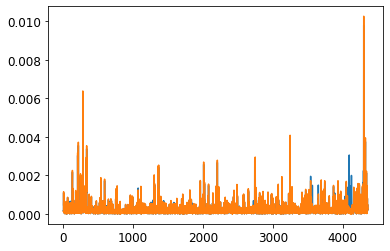

In [284]:
# First Eigenvector of TM
plt.plot(ATMs[d][0]);
plt.plot(APM[0]);

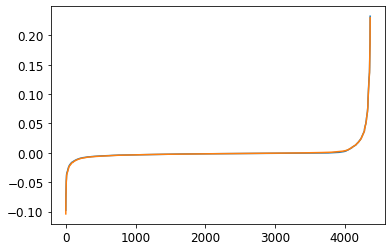

In [276]:
# Second Eigenvector of TM
plt.plot(np.sort(ATMs[d][1]));
plt.plot(np.sort(APM[1]));

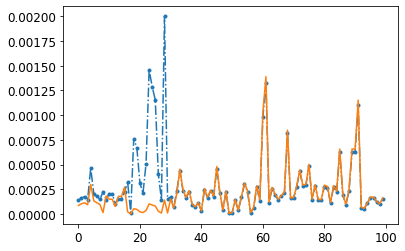

In [277]:
font = {'size': 12}
plt.rc('font', **font)
plt.plot(ATMs[d][0][4100:4200], '.-.');
plt.plot(APM[0][4100:4200]);

In [278]:
ADF = 100*(APM[0]-ATMs[d][0])/ATMs[d][0]

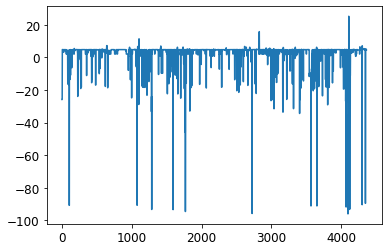

In [279]:
plt.plot(ADF);

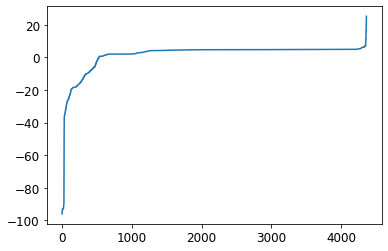

In [280]:
plt.plot(np.sort(ADF));

In [281]:
# Steady distribution of common stations
common_states = []
for i, vector in enumerate(Vs):
    _vector = vector.copy(deep=True)
    if i == d:
        _vector['color'] = ADF
    _vector['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    _vector['Flag'] = _vector['station'].isin(indices)
    _vector = _vector[_vector['Flag']]   
    _vector.set_index('station', inplace=True)
    _vector.loc[:, 'lon'] = commonloc.geopos.map(lambda x: x[0])
    _vector.loc[:, 'lat'] = commonloc.geopos.map(lambda x: x[1])
    common_states.append(_vector)

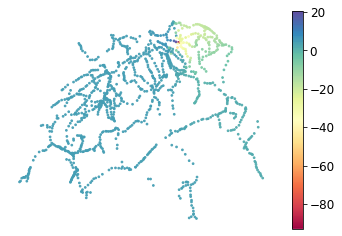

In [283]:
x = common_states[d].lon.values
y = common_states[d].lat.values
c = common_states[d].color
#plt.style.use('dark_background')
aspect = plt.rcParams['figure.figsize']
fig = plt.figure()
im = plt.scatter(
    x,
    y,
    c=c,
    norm=mpl.colors.Normalize(vmin=c.min(),vmax=c.max()),
    s=3,
    cmap = plt.cm.Spectral,
    alpha=.9)

fig.colorbar(im)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
# blackout_stations = [target]
#blackout_stations = list(indices)
# for d in range(len(TMs[:1])):
    #TM = TMs[d].copy(deep=True)

#     names_perturbed = []
#     indices_perturbed = []

#     Pi_perturbed = []
#     Pi_diff = []

    #e0 = time.time()
    
#     pi_normal = ATM[0]

    #for station in tqdm(blackout_stations):
#     for station in blackout_stations:
#         ind = np.where(TM.index == station)[0][0]
#     Perturbed_TM = PM#change_node(TM.values, ind, percent)
#         e0 = time.time()
#     pi = APM[0]#pi, _ = simulate_markov(PM, verbose='on', thres=1e-6, cycles=2*1e5)
#         print("Sensitivity of TM {}, in {} second".format(
#             datetime(year=2019, month=10, day=int(d + 1)),
#             time.time() - e0))


#         indices_perturbed.append(ind)
#         names_perturbed.append(station)
#         Pi_perturbed.append(pi)
#     Pi_diff.append(np.asarray(100 * (pi - pi_normal) / pi_normal))

#     DF = pd.DataFrame(
#         index=names_perturbed, data=np.asarray(Pi_diff), columns=TM.index)
#     path = 'data/istdaten/{}/perturbations/{}/Pi_diff_{}_{:>02}{}2019.pkl'.format(
#         month, folder, str(percent), str(d + 1), imonth)
#     DF.to_pickle(path)

#     DF = pd.DataFrame(
#         index=['pi_normal'],
#         data=np.asarray(pi_normal)[np.newaxis, :],
#         columns=TM.index)
#     path = 'data/istdaten/{}/perturbations/{}/pi_normal_{}_{:>02}{}2019.pkl'.format(
#         month, folder, str(percent), str(d + 1), imonth)
#     DF.to_pickle(path)

#     DF = pd.DataFrame(
#         index=names_perturbed,
#         data=np.asarray(Pi_perturbed),
#         columns=TM.index)
#     path = 'data/istdaten/{}/perturbations/{}/Pi_perturbed_{}_{:>02}{}2019.pkl'.format(
#         month, folder, str(percent), str(d + 1), imonth)
#     DF.to_pickle(path)

In [ ]:
period = 1

In [ ]:
max_list = []
min_list = []
for i in range(0, period):
#     pi_diff_path = 'data/istdaten/{}/perturbations/{}/Pi_diff_{}_{:>02}{}2019.pkl'.format(
#         month, folder, (percent), str(i + 1), imonth)
#     pi_diff = pd.read_pickle(pi_diff_path)
#     pi_diff = pi_diff[list(indices)]
    pi_diff = Pi_diff[0]#pi_diff.loc[[target]]
    max_list.append(max(pi_diff))
    min_list.append(min(pi_diff))

In [ ]:
def scatterplot(d, target, stations, fontsize, dotsize, alpha, vmin, vmax):
    font = {'size': fontsize}
    plt.rc('font', **font)
    
    Steady_dist = Vs[d].copy(deep=True)
    Steady_dist['Pi'] = Pi[d].values
    Steady_dist.loc[:, 'color'] = Pi_diff[0]#pi_diff.T[target].values
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(d + 1)))
    Steady_dist['Flag'] = Steady_dist['station'].isin(stations)
    Steady_dist = Steady_dist[Steady_dist['Flag']]   
    Steady_dist.set_index('station', inplace=True)
    Steady_dist.loc[:, 'lon'] = commonloc.geopos.map(lambda x: x[0])
    Steady_dist.loc[:, 'lat'] = commonloc.geopos.map(lambda x: x[1])
    x = Steady_dist.lon.values
    y = Steady_dist.lat.values
    sc = plt.scatter(x, y, c=Steady_dist.color, lw=0, s=dotsize, alpha=alpha, cmap=plt.cm.RdYlBu)
    plt.clim(vmin=vmin, vmax=vmax)
    plt.axis('off')
    return sc

In [ ]:
msz10 = 5
msz11 = 7
week = ['M', 'T', 'W', 'T', 'F', 'S', 'S']
fontsize = 25
aspect = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(aspect[0]*msz11, aspect[1]*msz10))
for i in range(2, 2+period):
#     pi_diff_path = 'data/istdaten/{}/perturbations/{}/Pi_diff_{}_{:>02}{}2019.pkl'.format(
#         month, folder, (percent), str(i - 1), imonth)
#     pi_diff = pd.read_pickle(pi_diff_path)
#     pi_diff = pi_diff[list(indices)]
    plt.subplot(msz10, msz11, i)
    plt.axis('off')
    target = 'target'
    stations = indices
    im = scatterplot(i-2, target, stations, fontsize=fontsize, dotsize=20,
                     alpha=1, vmin=min(min_list), vmax=0)
    plt.title(week[(i-1)%7], fontsize=fontsize)
        
#path = 'C:/Users/Georgios/Desktop/Paper/Luzern.jpg'
#fig.savefig(path, dpi=300, bbox_inches='tight')

#cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])

#fig.colorbar(im, cbar_ax)
fig.colorbar(im)
plt.show()
plt.close()

In [ ]:
msz10 = 5
msz11 = 7
week = ['M', 'T', 'W', 'T', 'F', 'S', 'S']
fontsize = 25
aspect = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(aspect[0]*msz11, aspect[1]*msz10))
for i in range(2, 3):
    pi_diff_path = 'data/istdaten/{}/perturbations/{}/Pi_diff_{}_{:>02}{}2019.pkl'.format(
        month, folder, (percent), str(i - 1), imonth)
    pi_diff = pd.read_pickle(pi_diff_path)
    pi_diff = pi_diff[list(indices)]
    plt.subplot(msz10, msz11, i)
    plt.axis('off')
    target = target
    stations = indices
    im = scatterplot(i-2, target, stations, fontsize=fontsize, dotsize=20,
                     alpha=1, vmin=min(min_list), vmax=max(max_list))
    plt.title(week[(i-1)%7], fontsize=fontsize)
        
#path = 'C:/Users/Georgios/Desktop/Paper/Luzern.jpg'
#fig.savefig(path, dpi=300, bbox_inches='tight')

cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cbar_ax)
plt.show()
plt.close()

## Graph Utilities

In [ ]:
def station_graph(index):
    TM = TMs[index]
    timestamp = pd.DataFrame({'year': [2019], 'month': [10], 'day': [index + 1]})
    # Construct the graph
    G = nx.MultiDiGraph()
    for i, origin_state in enumerate(list(TM.index)):
        for j, destination_state in enumerate(list(TM.columns)):
            rate = TM.iloc[i, j]
            if rate > 0:
                G.add_edge(
                    origin_state,
                    destination_state,
                    weight=rate,
                    Flag = True,
                    Date=str(pd.to_datetime(timestamp)[0]))
    attrs = steady_states[index].T.to_dict()
    nx.set_node_attributes(G, attrs)
    return G

### Interactive Plots

In [ ]:
def plot_station_graph(index=15, geo=True, labels=False, mode='contextual', cmap=plt.cm.RdYlBu_r):
    G = station_graph(index)
    bond = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    # Get pagerank metrics on each node
    pi = np.array(list(nx.get_node_attributes(G, 'Pi').values()))
    # Filter transitions out
    flag = np.array(list(nx.get_node_attributes(G, 'Flag').values()))    
    
    bar = False
    
    if mode=='contextual':
        color = np.array(list(nx.get_node_attributes(G, 'color').values()))
        edge_cmap = plt.cm.Greys_r
        outline = 'black'
        bar = True
    elif mode=='degree':
        degree = np.array(list(nx.degree_centrality(G).values()))
        color = np.log(np.divide(1, degree))
        edge_cmap = plt.cm.Greys_r
        outline = 'black'
    elif mode=='closeness':
        closeness = np.array(list(nx.closeness_centrality(G).values()))
        color = np.log(np.divide(1, closeness))
        edge_cmap = plt.cm.Greys_r
        outline = 'black'
    elif mode=='betweenness':
        # Include endpoints to avoid division by zero 
        betweenness = np.array(list(nx.betweenness_centrality(G, weight=None, endpoints=True).values()))
        color = np.log(np.divide(1, betweenness))
        edge_cmap = plt.cm.Greys_r
        outline = 'black'
    elif mode=='binary':
        degree = np.array(list(nx.degree_centrality(G).values()))
        color = np.where(degree <= np.unique(degree)[3], 255, 0)
        edge_cmap = plt.cm.Greys_r
        outline = 'black'
    elif mode=='default':
        color = 'Blue'
        edge_cmap = plt.cm.Blues_r
        outline = None

    # Layout
    pos = nx.spring_layout(G, seed=1)
    if not geo:
        plt.figure(figsize=(50, 50))
        nx.draw(
            G,
            pos=pos,
            edge_color=bond,
            node_color=color,
            cmap=cmap,
            edge_cmap=edge_cmap,
            with_labels=labels,
            font_weight=1,
            node_size=pi * pow(10, 6) * flag,
            width=bond * 10,
            alpha=0.5)
    elif geo:
        # Overwrite random graph positions with the georeferenced locations
        geopos = pos.copy()
        for key, value in geopos.items():
            if '=>' in key:
                pair = key.split('=>')
                posA = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == pair[0]].geopos.values[0])
                posB = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == pair[1]].geopos.values[0])
                geopos[key] = list((posA+posB)/2.0)
            else:
                geopos[key] = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == key].geopos.values[0])   
                
        aspect = plt.rcParams["figure.figsize"]
        plt.figure(figsize=(aspect[0]*10, aspect[1]*10))

        nx.draw(
            G,
            pos=geopos,
            edge_color=bond,
            node_color=color,
            cmap=cmap,
            edge_cmap=edge_cmap,
            with_labels=labels,
            font_weight=30,
            node_size=pi * pow(10, 6.5) * flag,
            width=bond * 5,
            alpha=0.5)
        
    if bar:        
        vmin = min(color)
        vmax = max(color)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
        sm._A = []
        font = {'size': 50}
        plt.rc('font', **font)
        plt.colorbar(sm, aspect=50)
        ax= plt.gca()
        ax.collections[0].set_edgecolor(outline)

        plt.axis('off')
        plt.show()
    else:
        ax= plt.gca()
        ax.collections[0].set_edgecolor(outline)

        plt.axis('off')
        plt.show()        

## Graph Theory

In [ ]:
# Steady distribution of common stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector.copy(deep=True)
    Steady_dist['Pi'] = Pi[i].values
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    Steady_dist['Flag'] = Steady_dist['station'].isin(indices) 
    Steady_dist.set_index('station')
    Steady_dist_ = Steady_dist[Steady_dist['Flag']]    
    Steady_dist = Steady_dist.merge(Steady_dist_, how='outer')
    Steady_dist = Steady_dist.fillna(0)
    Steady_dist.set_index('station', inplace=True)
    steady_states.append(Steady_dist)

In [ ]:
plot_station_graph(mode='default')

In [ ]:
G = station_graph(index=day)

In [ ]:
# Get pagerank metrics on each node
pi = np.array(list(nx.get_node_attributes(G, 'Pi').values()))
# Filter transitions out
flag = np.array(list(nx.get_node_attributes(G, 'Flag').values()))

In [ ]:
origin = np.array(list(nx.get_node_attributes(G, 'origin').values()))
inflow = np.array(list(nx.get_node_attributes(G, 'inflow').values()))
outflow = np.array(list(nx.get_node_attributes(G, 'outflow').values()))

In [ ]:
name = np.array(list(G.nodes.keys()))

In [ ]:
degree = np.array(list(nx.out_degree_centrality(G).values()))

In [ ]:
closeness = np.array(list(nx.closeness_centrality(G).values()))

In [ ]:
# Include endpoints to avoid division by zero 
betweenness = np.array(list(nx.betweenness_centrality(G, weight=None, endpoints=True).values()))

In [ ]:
# create a dictionary
dic = {
    'degree': np.log(degree),
    'betweenness': np.log(betweenness),
    'closeness': np.log(closeness),
    'pi': np.log(pi),
    'flag': flag
}

# create a list of strings
columns = ['degree', 'betweenness', 'closeness', 'pi', 'flag']

df = pd.DataFrame(dic, columns=columns)
df = df[df['flag']] 
df.reset_index(inplace=True, drop=True)

In [ ]:
np.unique(df.degree)

In [ ]:
lowcon = np.where(df.degree <= np.unique(df.degree)[0], True, False)

In [ ]:
indices[lowcon]

In [ ]:
# Create a pair grid instance
font = {'size': 15}
plt.rc('font', **font)
grid = sns.PairGrid(df[['degree', 'betweenness', 'closeness', 'pi']], height=3.5)
grid = grid.map_lower(plt.scatter, s=20,
                      color='white', edgecolor='b', alpha=.5, lw=.4)
grid = grid.map_upper(sns.kdeplot, color='b', shade=True,
                      shade_lowest=False, alpha=0.5, n_levels=1000)
grid = grid.map_diag(sns.kdeplot, shade=True, color='b', lw=.9);
#grid.set(xticks=[])
#grid.set(yticks=[])
path = 'C:/Users/Georgios/Desktop/Paper/pairplot.jpg'
grid.savefig(path, dpi=300, bbox_inches='tight')

### Degree centrality

In [ ]:
plot_station_graph(index=10, cmap=plt.cm.bwr, mode='binary')

### Graph-Theoritical Clustering

In [ ]:
from sompy import mapview
from sompy.sompy import SOMFactory

In [ ]:
# create a dictionary
dic = {
    'name': name,
    'degree': np.log(degree),
    'betweenness': np.log(betweenness),
    'closeness': np.log(closeness),
    'pi': np.log(pi),
    'origin': origin,
    'inflow': inflow,
    'outflow': outflow,
    'flag': flag
}

# create a list of strings
columns = ['name', 'degree', 'betweenness', 'closeness', 'pi', 'origin', 'inflow', 'outflow', 'flag']

df = pd.DataFrame(dic, columns=columns)
df = df[df['flag']] 
del df['flag']
df.sort_values(by=['name'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [ ]:
centralities = ['degree', 'betweenness', 'closeness', 'pi']

In [ ]:
X = df[centralities].values

In [ ]:
#Normal = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

In [ ]:
print(min_max_scaler.fit(X))

In [ ]:
Normal = min_max_scaler.transform(X)

### 2-dimensional SOM

In [ ]:
msz10 = 70
msz11 = 50

In [ ]:
som2 = SOMFactory().build(Normal, lattice='hexa', mapsize=[msz10, msz11], normalization='var',
                        initialization='pca', component_names=centralities)
som2.train(n_job=1, verbose=False, train_rough_len=20, train_finetune_len=50)

In [ ]:
topographic_error = som2.calculate_topographic_error()
quantization_error = np.mean(som2._bmu[1])
print("Topographic error = %s; Quantization error = %s" % (topographic_error,
                                                           quantization_error))

In [ ]:
from sompy.visualization.mapview import View2D
view2D  = View2D('','','',text_size=10)
view2D.show(som2, what='codebook', which_dim='all', cmap=plt.cm.RdYlBu_r, col_sz=4.1, denormalize=True)

### 1-dimensional SOM with contextual numbers

In [ ]:
import sompylib.sompy as SOM

In [ ]:
# create a dictionary
dic = {
    'name': name,
    'degree': degree,
    'betweenness': betweenness,
    'closeness': closeness,
    'pi': pi,
    'origin': origin,
    'inflow': inflow,
    'outflow': outflow,
    'flag': flag
}

# create a list of strings
columns = ['name', 'degree', 'betweenness', 'closeness', 'pi', 'origin', 'inflow', 'outflow', 'flag']

df = pd.DataFrame(dic, columns=columns)
df = df[df['flag']] 
del df['flag']
df.sort_values(by=['name'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [ ]:
centralities = ['degree', 'betweenness', 'closeness', 'pi']

In [ ]:
X = df[centralities].values

In [ ]:
#Normal = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

In [ ]:
print(min_max_scaler.fit(X))

In [ ]:
Normal = min_max_scaler.transform(X)

In [ ]:
def denormalize_by(data_by, n_vect, n_method = 'var'):
    #based on the normalization
    if n_method == 'var':
        me = np.mean(data_by, axis = 0)
        st = np.std(data_by, axis = 0)
        vect = n_vect* st + me
        return vect 
    else:
        print('data is not normalized before')
        return n_vect

In [ ]:
msz1 =1
msz0 = 120
data = Normal
somCN= SOM.SOM('som1', data, mapsize = [msz0, msz1],norm_method = 'var',initmethod='pca')
somCN.train(n_job = 1, shared_memory = 'no',verbose='final')
codebook_CN= denormalize_by(somCN.data_raw, somCN.codebook[:], n_method = 'var')

In [ ]:
dim1 = 2
dim2 = 0

In [ ]:
fig = plt.figure()
K = codebook_CN.shape[0]
plt.plot(data[:,dim1],data[:,dim2],'.',alpha=.1, c = 'Black')
c = range(codebook_CN.shape[0])
plt.scatter(codebook_CN[:,dim1],codebook_CN[:,dim2],s=60,marker='o',alpha=1.,c=plt.cm.RdYlBu_r(np.asarray(c)/float(K)));
plt.plot(codebook_CN[:,dim1],codebook_CN[:,dim2],'-',alpha=.5, c='Grey')
fig.set_size_inches(9,9);

In [ ]:
proj = somCN.project_data(data)

In [ ]:
# Python 3 program to replace the elements 
# by their frequency in the array. 
  
def ReplaceElementsByFrequency(arr, n): 
    newarr = []  
    # Hash map which will store the 
    # frequency of the elements of the array. 
    mp = {i:0 for i in range(len(arr))} 
  
    for i in range(n): 
          
        # Increment the frequency of the  
        # element by 1. 
        mp[arr[i]] += 1
  
    # Replace every element by its frequency 
    for i in range(n): 
        newarr.append(mp[arr[i]])
    return np.array(newarr)

In [ ]:
bins = ReplaceElementsByFrequency(proj, len(proj))

In [ ]:
# Euclidean metric of weights
w = codebook_CN
HDist = []
for i, _ in enumerate(w):
    if i>=1:
        HDist.append(np.linalg.norm(w[i]-w[i-1]))
HDist = HDist/min(HDist)

In [ ]:
# Calclulate adjusted contextual numbers (ACNs)
acn = []
ACN = 0
acn.append(ACN)
for i in range(1, len(HDist)+1):
    ACN = ACN + HDist[i-1]
    acn.append(ACN)

In [ ]:
# Match results to ACNs
newproj=[]
for pr in proj:
    newpr = acn[pr]
    newproj.append(newpr)

In [ ]:
# Interpolate between 0 and 1
interpol = np.interp(newproj, (min(newproj), max(newproj)), (0, 1))

In [ ]:
from matplotlib.collections import EllipseCollection

x = np.arange(0, len(acn), 1)
y = acn

font = {'size': 20}
plt.rc('font', **font)
fig, ax = plt.subplots()
plt.plot(x, y, 'black', linewidth=.51, linestyle='-.')
plt.grid(linewidth=.31, color='gray', linestyle='--')
plt.xlabel('CN')
plt.ylabel('ACN')

offsets = list(zip(proj, newproj))

scatter = ax.add_collection(EllipseCollection(widths=bins, heights=bins, angles=0, units='x',
                                       facecolors=plt.cm.RdYlBu_r(interpol),
                                       offsets=offsets, transOffset=ax.transData, alpha=0.5))

fig.set_size_inches(10,10);

path = 'C:/Users/Georgios/Desktop/Paper/ACN.jpg'
fig.savefig(path, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

In [ ]:
labels=np.array(centralities)
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
fig=plt.figure(figsize=(10, 10))
font = {'size': 20}
plt.rc('font', **font)
ax = fig.add_subplot(111, polar=True)
for i in range(len(X)):
    stats=Normal[i]
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, '-', alpha=0.2, linewidth=5, color=cm.RdYlBu_r(interpol[i]))
    ax.fill(angles, stats, alpha=0.4, color=cm.RdYlBu_r(interpol[i]))
ax.set_thetagrids(angles * 180/np.pi, labels)
#ax.set_title('Centralities')
ax.grid(linewidth=0.75, color='black', linestyle=(0, (1, 5)))
ax.spines['polar'].set_visible(False)
path = 'C:/Users/Georgios/Desktop/Paper/radar.jpg'
fig.savefig(path, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

In [ ]:
# Steady distribution of stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector.copy(deep=True)
    Steady_dist['Pi'] = Pi[i].values
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    Steady_dist['Flag'] = Steady_dist['station'].isin(indices)  
    Steady_dist.set_index('station')
    Steady_dist_ = Steady_dist[Steady_dist['Flag']]    
    Steady_dist_['color'] = interpol
    Steady_dist = Steady_dist.merge(Steady_dist_, how='outer')
    Steady_dist = Steady_dist.fillna(0)
    Steady_dist.set_index('station', inplace=True)
    steady_states.append(Steady_dist)

In [ ]:
plot_station_graph(index=10, cmap=plt.cm.RdYlBu_r)

### Perturbed Data

In [ ]:
d = 10

In [ ]:
pi_normal_path = 'data/istdaten/{}/perturbations/Sample/pi_normal_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
pi_normal = pd.read_pickle(pi_normal_path)
pi_normal = pi_normal[list(indices)]

pi_perturbed_path = 'data/istdaten/{}/perturbations/Sample/Pi_perturbed_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
pi_perturbed = pd.read_pickle(pi_perturbed_path)
pi_perturbed = pi_perturbed[list(indices)]

pi_diff_path = 'data/istdaten/{}/perturbations/Sample/Pi_diff_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
pi_diff = pd.read_pickle(pi_diff_path)
pi_diff = pi_diff[list(indices)]

In [ ]:
minimum = pi_diff.min(axis=1)

In [ ]:
maximum = pi_diff.max(axis=1)

In [ ]:
#posfilter = (pi_diff > 0).any(axis=1).values
#diff = (pi_diff.max(axis=1) - pi_diff.min(axis=1)).values
negfilter = (np.logical_and(maximum.values<=15, minimum.values<=0))
posfilter = [not c for c in negfilter]

In [ ]:
poslist = list(compress(list(indices), posfilter))
poslist.sort()
neglist = list(compress(list(indices), negfilter))
neglist.sort()

In [ ]:
len(poslist)

In [ ]:
len(neglist)

In [ ]:
city='Baldegg'
print(city)
print('IN')
for n, i in enumerate(TMs[0][[city]].values.T[0]):
    if i > 0:
        print(i, TMs[0].iloc[n].name)
print('OUT')
for n, i in enumerate(TMs[0].loc[[city]].values[0]):
    if i > 0:
        print(i, TMs[0].iloc[n].name)

In [ ]:
city='Baldegg Kloster'
print(city)
print('IN')
for n, i in enumerate(TMs[0][[city]].values.T[0]):
    if i > 0:
        print(i, TMs[0].iloc[n].name)
print('OUT')
for n, i in enumerate(TMs[0].loc[[city]].values[0]):
    if i > 0:
        print(i, TMs[0].iloc[n].name)

In [ ]:
for city in poslist:
    print(city)
    print('IN')
    for n, i in enumerate(TMs[0][[city]].values.T[0]):
        if i > 0:
            print(i, TMs[0].iloc[n].name)
    print('OUT')
    for n, i in enumerate(TMs[0].loc[[city]].values[0]):
        if i > 0:
            print(i, TMs[0].iloc[n].name)
    print()

In [ ]:
pi_normal = pi_normal[neglist]
pi_diff = pi_diff[neglist].drop(poslist)
pi_perturbed = pi_perturbed[neglist].drop(poslist)

In [ ]:
vmax = pi_diff.max(axis=1).max()
vmax

In [ ]:
vmin = pi_diff.min(axis=1).min()
vmin

## Clustering

In [ ]:
from sompy import mapview
from sompy.sompy import SOMFactory

In [ ]:
import sompylib.sompy as SOM

In [ ]:
# Normalize along the rows!
row_sums = pi_perturbed.T.values.sum(axis=1)
Normal = pi_perturbed.T.values / row_sums[:, np.newaxis]

In [ ]:
from sklearn.preprocessing import normalize
Normal = normalize(pi_perturbed.T.values, axis=1, norm='l1')

### 2-dimensional SOM

In [ ]:
msz11 = 7
msz10 = 14

In [ ]:
som = SOMFactory().build(
    Normal, mapsize=[msz10, msz11], initialization='pca', component_names=neglist)
som.train(n_job=1, verbose=False, train_rough_len=100, train_finetune_len=250)

In [ ]:
dists,bmus = som.find_k_nodes(som.data_raw,k=1)

In [ ]:
topographic_error = som.calculate_topographic_error()
quantization_error = np.mean(som._bmu[1])
print("Topographic error = %s; Quantization error = %s" % (topographic_error,
                                                           quantization_error))

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView
vhts  = BmuHitsView(10,10,"Hits Map",text_size=10)
vhts.show(som, anotate=True, onlyzeros=True, labelsize=10, cmap=plt.cm.RdYlBu_r, logaritmic=True)
plt.show()

In [ ]:
aspect = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(aspect[0]*msz11, aspect[1]*msz10))
for i in range(1, msz10*msz11+1):
    plt.subplot(msz10, msz11, i)
    plt.axis('off')
    ind_node_i = np.where(bmus==i-1)[0]
    if ind_node_i.any():
        index = ind_node_i[dists[ind_node_i].argmin()]
        target = neglist[index]
        stations = neglist
        im = scatterplot(d, target, stations, fontsize=20, dotsize=20, vmin=vmin, vmax=vmax, alpha=1.0)
        plt.title(target, fontsize=25)
    else:
        pass#plt.text(0.5, 0.5, str((msz10, msz11, i)), fontsize=25, ha='center')
path = 'C:/Users/Georgios/Desktop/Paper/SOM_{}_{}2019.jpg'.format(
        month, str(d + 1), imonth)
fig.savefig(path, dpi=300, bbox_inches='tight')
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cbar_ax)
plt.show()
plt.close()

## Calculating Systemic Influence, Systemic Fragility and other measures

In [ ]:
d = 10

In [ ]:
pi_normal_path = 'data/istdaten/{}/perturbations/Sample/pi_normal_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
pi_normal = pd.read_pickle(pi_normal_path)
pi_normal = pi_normal[list(indices)]

pi_perturbed_path = 'data/istdaten/{}/perturbations/Sample/Pi_perturbed_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
pi_perturbed = pd.read_pickle(pi_perturbed_path)
pi_perturbed = pi_perturbed[list(indices)]

pi_diff_path = 'data/istdaten/{}/perturbations/Sample/Pi_diff_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
pi_diff = pd.read_pickle(pi_diff_path)
pi_diff = pi_diff[list(indices)]

In [ ]:
# Threshold of change in pct
thresh = 20

dim = pi_diff.shape[1]

In [ ]:
# Systemic Influence
no_of_pos_affecting = (pi_diff.values[:dim, :dim] > thresh).sum(axis=1)
no_of_neg_affecting = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=1)

ind_pos_affecting = pi_diff.values[:dim, :dim] > thresh
ind_neg_affecting = pi_diff.values[:dim, :dim] < -1 * thresh
pos_affecting = np.zeros(dim)
neg_affecting = np.zeros(dim)

for i in range(dim):
    pos_affecting[i] = pi_diff.values[i, ind_pos_affecting[i]].dot(
        pi_normal.values[0, :dim][ind_pos_affecting[i]])
    neg_affecting[i] = pi_diff.values[i, ind_neg_affecting[i]].dot(
        pi_normal.values[0, :dim][ind_neg_affecting[i]])
    
sum_of_affecting = np.abs(neg_affecting) + pos_affecting

#systemic_influence = (no_of_pos_affecting + no_of_neg_affecting) / float(dim)
systemic_influence = (sum_of_affecting) / float(sum_of_affecting.max())

In [ ]:
# Systemic Fragility
no_of_pos_affected = (pi_diff.values[:dim, :dim] > thresh).sum(axis=0)
no_of_neg_affected = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=0)

ind_pos_affected = pi_diff.values[:dim, :dim] > thresh
ind_neg_affected = pi_diff.values[:dim, :dim] < -1 * thresh
pos_affected = np.zeros(dim)
neg_affected = np.zeros(dim)

for i in range(dim):
    pos_affected[i] = pi_diff.values[ind_pos_affected[:dim, i],
                                     i].sum() * pi_normal.values[0, i]
    neg_affected[i] = pi_diff.values[ind_neg_affected[:dim, i],
                                     i].sum() * pi_normal.values[0, i]

# We want to take out the effect each node on itself
self_change = np.diag(pi_diff.values[:, :dim]) * pi_normal.values[0, :dim]
sum_of_affected = np.abs(neg_affected) + pos_affected - np.abs(self_change)    
    
systemic_fragility = (no_of_pos_affected + no_of_neg_affected) / float((no_of_pos_affected + no_of_neg_affected).max())
#systemic_fragility = (sum_of_affected) / float(dim)

### Systemic fragility vs. systemic influence

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)
font = {'size': 12}
plt.rc('font', **font)

ax = plt.gca()

x = systemic_fragility
y = systemic_influence
z = pi_normal.values[0]

p = plt.scatter(
    x,
    y,
    c='white',
    s=z * pow(10, 5.5),
    marker='o',
    edgecolor='Blue',
    cmap=plt.cm.Blues_r,
    alpha=0.5)

plt.xlabel('systemic fragility (absolute change > {}%)'.format(thresh))
plt.ylabel('systemic influence (absolute change > {}%)'.format(thresh))

xmin = x.min() - 0.01
xmax = x.max() + 0.01

ymin = y.min() - 0.02
ymax = y.max() + 0.1

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

font = {'size': 14.}

plt.rc('font', **font)
plt.tight_layout()

#path = 'C:/Users/GAO/Desktop/ML/ETH/Paper/plt.jpg'
#fig.savefig(path, dpi=300)

plt.show();
plt.close();

### Systemic fragility

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)

ax = plt.gca()
ax.set_xscale('log')
metric = systemic_fragility
y = metric
x = pi_normal.values[0]
z = pi_normal.values[0]

p = plt.scatter(
    x,
    y,
    c='white',
    s=z * pow(10, 5.5),
    marker='o',
    edgecolor='Blue',
    cmap=plt.cm.Blues_r,
    alpha=0.5)

plt.ylabel('systemic fragility (absolute change > {}%)'.format(thresh))
plt.xlabel('log scale-steady state probability (structural power)')

xmin = x.min() / 1.5
xmax = x.max() + 0.01

ymin = y.min() - 0.01
ymax = y.max() + 0.01

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

font = {'size': 14.}

plt.rc('font', **font)
plt.tight_layout()

#path = 'C:/Users/GAO/Desktop/ML/ETH/Paper/fragility_plt.jpg'
#fig.savefig(path, dpi=300)

plt.show();
plt.close();

In [ ]:
# Steady distribution of stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector.copy(deep=True)
    Steady_dist['Pi'] = Pi[i].values
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    Steady_dist['Flag'] = Steady_dist['station'].isin(indices)
    array = []
    measure = systemic_fragility
    count = 0
    if i==d:
        for j, boo in enumerate(Steady_dist['Flag']):
            if boo:
                array.append(measure[count])
                count+=1
            else:
                array.append(min(measure))
        Steady_dist['color'] = array
    Steady_dist.set_index('station', inplace=True)
    steady_states.append(Steady_dist)

In [ ]:
plot_station_graph(index=10, cmap=plt.cm.RdYlBu_r)

### Top 10 nodes with the lowest systemic fragility

In [ ]:
dd = np.concatenate(
    (pi_normal.T.index.values[:][:, np.newaxis],
     pi_normal.T['pi_normal'].values[:][:, np.newaxis],
     systemic_fragility[:, np.newaxis],
     systemic_influence[:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
    ])

DF.head()
DF = DF.sort_values(['Systemic Fragility', 'structural power'], ascending=[True, True])
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

### Top 10 nodes with the highest systemic fragility

In [ ]:
dd = np.concatenate(
    (pi_normal.T.index.values[:][:, np.newaxis],
     pi_normal.T['pi_normal'].values[:][:, np.newaxis],
     systemic_fragility[:, np.newaxis],
     systemic_influence[:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
    ])

DF.head()
DF = DF.sort_values(['Systemic Fragility', 'structural power'], ascending=[False, False])
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

### Systemic influence

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)
font = {'size': 12}
plt.rc('font', **font)

ax = plt.gca()
ax.set_xscale('log')
metric = systemic_influence
y = metric
x = pi_normal.values[0]
z = pi_normal.values[0]

p = plt.scatter(
    x,
    y,
    c='white',
    s=z * pow(10, 5.5),
    marker='o',
    edgecolor='Blue',
    cmap=plt.cm.Blues_r,
    alpha=0.5)

plt.ylabel('systemic influence (absolute change > {}%)'.format(thresh))
plt.xlabel('log scale-steady state probability (structural power)')

xmin = x.min() / 1.5
xmax = x.max() + 0.01

ymin = y.min() - 0.02
ymax = y.max() + 0.1

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

font = {'size': 14.}

plt.rc('font', **font)
plt.tight_layout()

#path = 'C:/Users/GAO/Desktop/ML/ETH/Paper/influence_plt.jpg'
#fig.savefig(path, dpi=300)
plt.show();
plt.close();

In [ ]:
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector.copy(deep=True)
    Steady_dist['Pi'] = Pi[i].values
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    Steady_dist['Flag'] = Steady_dist['station'].isin(indices)
    array = []
    measure = systemic_influence
    count = 0
    if i==d:
        for j, boo in enumerate(Steady_dist['Flag']):
            if boo:
                array.append(measure[count])
                count+=1
            else:
                array.append(min(measure))
        Steady_dist['color'] = array
    Steady_dist.set_index('station', inplace=True)
    steady_states.append(Steady_dist)

In [ ]:
plot_station_graph(index=10, cmap=plt.cm.RdYlBu_r)

### Top 10 nodes with the highest systemic influence

In [ ]:
dd = np.concatenate(
    (pi_normal.T.index.values[:][:, np.newaxis],
     pi_normal.T['pi_normal'].values[:][:, np.newaxis],
     systemic_fragility[:, np.newaxis],
     systemic_influence[:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
    ])

DF.head()
DF = DF.sort_values(['Systemic Influence'], ascending=[False])
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

### Top 10 nodes with the lowest systemic influence

In [ ]:
dd = np.concatenate(
    (pi_normal.T.index.values[:][:, np.newaxis],
     pi_normal.T['pi_normal'].values[:][:, np.newaxis],
     systemic_fragility[:, np.newaxis],
     systemic_influence[:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
    ])

DF.head()
DF = DF.sort_values(['Systemic Influence'], ascending=[True])
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]